In [1]:
#%matplotlib widget


%matplotlib inline

import mpld3
mpld3.enable_notebook()

In [2]:
import copy
import numpy as np
from numpy import pi 
from numpy.random import rand
import matplotlib.pyplot as plt
#import scipy.fftpack as fft
import numpy.fft as fft
from math import pi
import time
import pydicom as dcm

plt.style.use('fivethirtyeight')
plt.style.use('default')

In [126]:
class SimSp():
    
     
    def __init__(self,BW=4000, SD = 0.256, recieverPhase=1, spec_ylim=[5,-1], name = 'Simulated MRS'):
        #super(SimSp, self).__init__()
        self.name = name       # Name you want to give to the simulated spectrum.
        self.BW = BW         # Bandwidth of the simulated spectrum [Hz]. ( BW=0.5/dt with dt is the sampling interval [s] ) 
        self.SD = SD     # Sampling duration of the signal [s]. ( SD=dt*(npoints-1[?])  with np is the number of samples )
        self.time0 = 0   # DONT USE. mimics phase shift proportional to frequency (For 1st order correction)
        self.B0 = 3          # Stregth of the main B0 field [T]
        self.spec_ylim=spec_ylim
        self.recieverPhase=recieverPhase # To mimic reciever phase (radians). (For 0 order correction)
        
        self.dt= 0.5/self.BW
        #self.npoints=int(self.SD*self.BW+1)
        self.npoints=int(self.SD/self.dt)
        print(self.npoints)
        
        self.t= np.linspace(self.time0,self.SD+self.time0,self.npoints)
        self.sig=np.zeros(self.t.shape)
        self.freq=np.zeros(self.t.shape)
        self.spec=np.zeros(self.t.shape)

        self.theta_autoshit=[]
        self.noiseval=[]
        
        self.apofuction=[]
        self.apostregth=[]
        
        self.npeaks=0
        self.mets=[]
        
        self.nuc = 'H'  # Nucleus giving the signal
        if self.nuc is 'H':
            self.gamma = 42.57747892  #   Nucleus	1H --> gyro= 267.5221900 [MRad/s/T] or  42.57747892 [MHz/T]
            self.carrier = self.gamma*self.B0  # Carrier frequency in MHz
            
    def addpeak(self,ppm=1, magnitude=1, phase=0 ,T2=200):
        self.ppm = ppm          # Chemical shift relative to TMS in ppm
        self.magnitude = magnitude         # Magniude of the signal 
        self.phase= phase     # Phase of the signal 
        self.T2=T2  # T2 of the resonance (ms)
        
        self.w = (self.ppm)*self.carrier*2*np.pi #demodulated angular frequency (Hz)
        self.npeaks+= 1  #peak counter
        #self.mets = self.mets.append("".join(map(str, ['Peak',self.npeaks])))    # Name of the molecule giving the nmr peak, e.g. Lac, Cho, NAA.
        self.sig=self.sig+self.magnitude*np.exp(1j*(self.w*(self.t-self.time0)+self.phase+self.recieverPhase))*np.exp(-(self.t-self.time0)*1000/self.T2)
       
    
        #print(self.npoints, self.dt)
        self.spec=fft.fftshift(fft.fft(self.sig))/self.npoints
        self.freq=fft.fftshift(fft.fftfreq(self.npoints))*2*self.BW
        #self.freq=np.linspace(-1,1,int(self.npoints))*self.BW/2;
    
        
    def autoshift(self, method='fast'):
        self.method = method
        if self.method==360:
            mysum=np.zeros(360)
            for ii in range(360):
                #theta2=theta-np.pi/4+np.pi/4/8*(ii)
                theta=2*pi/359*ii
                self.spec_shitted=self.spec*np.exp(-1j*theta)
                spreal=np.real(self.spec_shitted)
                mysum[ii]=np.sum(spreal)          
        
            pie360th=np.argmax(mysum)
            autotheta=2*pi/359*pie360th
        
            self.sig=self.sig*np.exp(-1j*autotheta)
            self.spec=fft.fftshift(fft.fft(self.sig))/self.npoints
                
        else:      
            mysum=np.zeros(20)
            for ii in range(20):
                theta=2*pi/20*ii
                #self.sig_shitted=self.sig*np.exp(1j*theta)
                #self.spec_shitted=fft.fftshift(fft.fft(self.sig_shitted))
                self.spec_shitted=self.spec*np.exp(-1j*theta)
                spreal=np.real(self.spec_shitted)
                mysum[ii]=np.sum(spreal)  

            pie20th=np.argmax(mysum)
            theta=2*pi/20*pie20th
            
            mysum=np.zeros(21)
            for ii in range(21):
                #theta2=theta-np.pi/4+np.pi/4/8*(ii)
                theta2=theta-pi/20+(pi/200*ii)
                #self.sig_shitted=self.sig*np.exp(1j*theta2)
                #self.spec_shitted=fft.fftshift(fft.fft(self.sig_shitted))
                self.spec_shitted2=self.spec*np.exp(-1j*theta2)
                spreal=np.real(self.spec_shitted2)
                mysum[ii]=np.sum(spreal)          

            pie400th=np.argmax(mysum)
            autotheta=theta-pi/20+(pi/200*pie400th)
            self.sig=self.sig*np.exp(-1j*autotheta)
            self.spec=fft.fftshift(fft.fft(self.sig))/self.npoints
            
        print(f'auto-shift method: {self.method}')    
        self.theta_autoshit=np.round(autotheta,1)
        

    def show(self,show_what=0):
        show_what=show_what
        #plt.figure()
        if show_what=='both':
            plt.subplot(2,1,1); plt.plot(self.t,np.real(self.sig)); plt.plot(self.t,np.imag(self.sig)); 
            plt.ylabel('Signal'); plt.xlabel('Time [s]');
            plt.title(self.name); plt.tight_layout()
       
        
            plt.subplot(2,1,2); plt.plot(self.freq/self.carrier,np.real(self.spec)); plt.plot(self.freq/self.carrier,np.imag(self.spec)); 
            #plt.subplot(2,1,2); plt.plot(self.freq,np.real(self.spec)); plt.plot(self.freq,np.imag(self.spec)); 

            plt.ylabel('Spectrum');  plt.xlabel('Frequency [ppm]')
            plt.legend(['Real','Imaginary'])
            plt.gca().invert_xaxis()
            plt.xlim(self.spec_ylim)
        
        elif show_what=='amplitude':
            plt.subplot(2,1,1); plt.plot(self.t,np.abs(self.sig))
            plt.ylabel('Signal magnitude'); plt.xlabel('Time [s]');
            plt.title(self.name); plt.tight_layout()
       
        
            plt.subplot(2,1,2); plt.plot(self.freq/self.carrier,np.abs(self.spec)); plt.plot(self.freq/self.carrier,np.angle(self.spec)); 
            #plt.subplot(2,1,2); plt.plot(self.freq,np.real(self.spec)); plt.plot(self.freq,np.imag(self.spec)); 

            plt.ylabel('Amplitude spectrum');  plt.xlabel('Frequency [ppm]')
            plt.legend(['Amplitude','Phase'])
            plt.gca().invert_xaxis()
            plt.xlim(self.spec_ylim)
        else:    
            plt.subplot(2,1,1); plt.plot(self.t,np.real(self.sig)); #plt.plot(self.t,np.imag(self.sig)); 
            plt.ylabel('Reals signal'); plt.xlabel('Time [s]');
            plt.title(self.name); plt.tight_layout()
       
        
            plt.subplot(2,1,2); plt.plot(self.freq/self.carrier,np.real(self.spec)); #plt.plot(self.freq/self.carrier,np.imag(self.spec)); 
            #plt.subplot(2,1,2); plt.plot(self.freq,np.real(self.spec)); plt.plot(self.freq,np.imag(self.spec)); 

            plt.ylabel('Real spectrum');  plt.xlabel('Frequency [ppm]')
            #plt.legend(['Real','Imaginary'])
            plt.gca().invert_xaxis()
            plt.xlim(self.spec_ylim)
        
    def addnoise(self,noiseval=1):
        self.noiseval=noiseval
        noise=rand(*self.sig.shape)*self.noiseval-noiseval/2
        self.sig=self.sig+noise
        self.spec=fft.fftshift(fft.fft(self.sig))/self.npoints
        
        
    def apodise(self,apofuction='Lorentz',apoval=-1.2, apoval2=1.7):
        self.apofuction=apofuction
        self.apoval=apoval
        self.apoval2=apoval2
        if self.apofuction=='half_exp':
            apod1=np.ones(int(self.npoints/2))
            apod2=np.exp(-np.linspace(0,self.apoval,self.npoints-int(self.npoints/2)))
            apod=np.append(apod1,apod2)
        elif self.apofuction=='exp':
            apod=np.exp(-np.linspace(0,self.apoval,self.npoints))
        else:
            apod=np.exp(-np.linspace(0,self.apoval,self.npoints)) * np.exp(-np.linspace(0,np.sqrt(self.apoval2),self.npoints)**2)     
                         
        self.sig=self.sig*apod
        self.spec=fft.fftshift(fft.fft(self.sig))/self.npoints     
        
        
        

2048


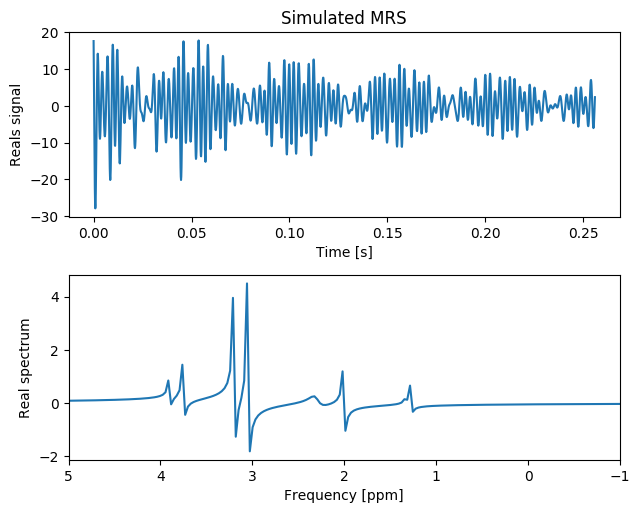

In [139]:
maris_nmr=SimSp(BW=4000,SD=0.256)      
  
maris_nmr.addpeak(ppm=3.9,magnitude=1.5, T2=180)  
maris_nmr.addpeak(ppm=3.75,magnitude=3, T2=180)  
maris_nmr.addpeak(ppm=3.2,magnitude=7,T2=250)  
maris_nmr.addpeak(ppm=3.05,magnitude=9,T2=250)  
maris_nmr.addpeak(ppm=2.3,magnitude=5, T2=20)  
maris_nmr.addpeak(ppm=2,magnitude=4, T2=250)  

maris_nmr.addpeak(ppm=1.32,magnitude=1.5, T2=350, phase=0*pi)  
maris_nmr.addpeak(ppm=1.28,magnitude=1.5, T2=350, phase=0*pi)  

plt.style.use('fivethirtyeight')
plt.style.use('default')

plt.figure()
maris_nmr.show()


auto-shift method: fast


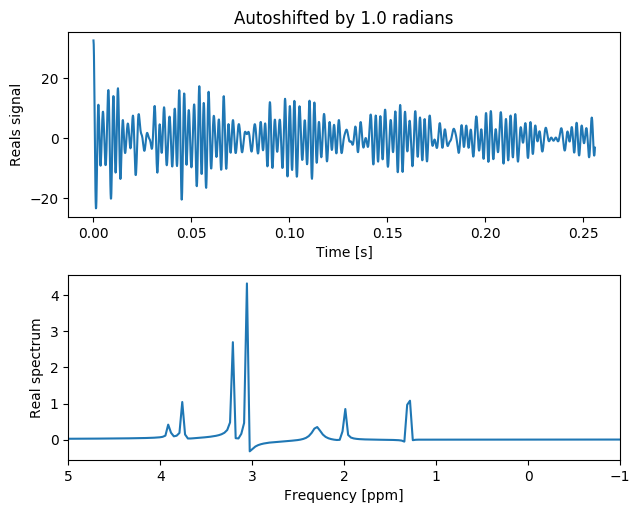

In [140]:
maris_nmr.autoshift()
maris_nmr.name=f'Autoshifted by {str(maris_nmr.theta_autoshit).format(2)} radians'

maris_nmr.show()
#plt.xlim([-20,20])

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:136: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:141: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


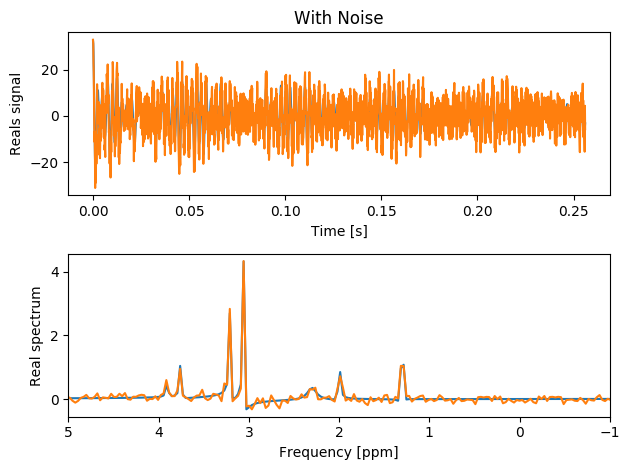

In [141]:
plt.figure()
maris_nmr.show('')
maris_nmr.addnoise(20)
maris_nmr.name='With Noise'
maris_nmr.show('')

#plt.style.use('fivethirtyeight')
#plt.style.use('default')



/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:136: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:141: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


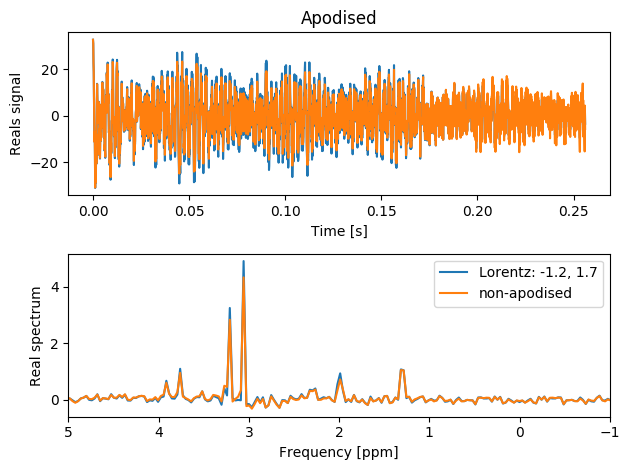

In [142]:
#mpld3.enable_notebook()

ap_nmr1=copy.copy(maris_nmr)
ap_nmr1.apodise('half_exp',apoval=2)
ap_nmr1.name='Half exponential'

ap_nmr2=copy.copy(maris_nmr)
ap_nmr2.apodise('exp',apoval=2)
ap_nmr2.name='Exponential'


ap_nmr3=copy.copy(maris_nmr)
ap_nmr3.apodise('Lorentz')
ap_nmr3.name='Lorentz'

maris_nmr.name='Apodised'

plt.figure()
ap_nmr3.show()
maris_nmr.show()


#plt.legend([f'half-exponential: {round(ap_nmr1.apoval,2)}','non-apodised'])  #1,mari
#plt.legend([f'exponential: {ap_nmr2.apoval}','non-apodised'])  #2,mari
plt.legend([f'Lorentz: {ap_nmr3.apoval}, {ap_nmr3.apoval2}','non-apodised'])  #3,mari

In [131]:
#realMRS=dcm.dcmread('/Users/patxi//Sync/myDocker/DICOMMRS/XX_0060')
realMRS=dcm.read_file('/Users/patxi//Sync/myDocker/DICOMMRS/XX_0060')
#realMRS=dcm.dcmread('/Users/papo/Sync/myDocker/DICOMMRS/XX_0060')
#realMRS2=dcm.read_file('/Users/papo/Sync/myDocker/DICOMMRS/XX_0060')

PatName = realMRS.PatientName
SpecData = realMRS[0x5600,0x0020].value
Datapoints = realMRS.DataPointColumns
SpectralWidth = realMRS.SpectralWidth
TransmitterFrequency = realMRS.TransmitterFrequency
FieldStrength = realMRS[0x0018,0x0087].value
            
PatID = realMRS.PatientID
ProtocolName = realMRS.ProtocolName            
Frames = realMRS.NumberOfFrames
displayTE = realMRS[0x2001, 0x1025].value




In [132]:
TransmitterFrequency,SpectralWidth


(127.739448, 3999.999755859375)

In [133]:
Datapoints,Frames

(2048, "32")

In [134]:


All_data=np.array(SpecData)
print(len(All_data)/2/2/16)

All_data_re=All_data[0:-2:2]
All_data_im=All_data[1:-1:2]

WS_data=All_data_re[0:int(len(All_data_re)/2):1]+1j*All_data_im[0:int(len(All_data_re)/2):1]
frames=[[],[]]

f1=WS_data[3*Datapoints:3*Datapoints+Datapoints:1]

# for ii in np.arange(16):
#     frame1=WS_data[ii*Datapoints:ii*Datapoints+Datapoints:1]
#     frames[ii,:]=frames
#     print(ii)

#plt.figure()
#plt.plot(f1)



2048.0


2048
auto-shift method: fast


(1, -4)

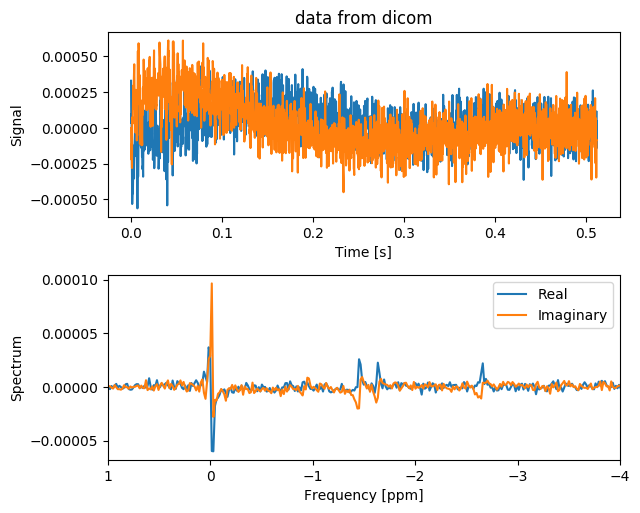

In [146]:
dicom1=SimSp(name='data from dicom',BW=2000,SD=0.256*2)

dicom1.sig=f1
dicom1.spec=fft.fftshift(fft.fft(dicom1.sig))/len(dicom1.sig)
dicom1.freq=fft.fftshift(fft.fftfreq(len(dicom1.sig)))*2*dicom1.BW

dicom1.autoshift()
plt.figure()

dicom1.show('both')
plt.xlim([1,-4])



2048
auto-shift method: fast


(1, -4)

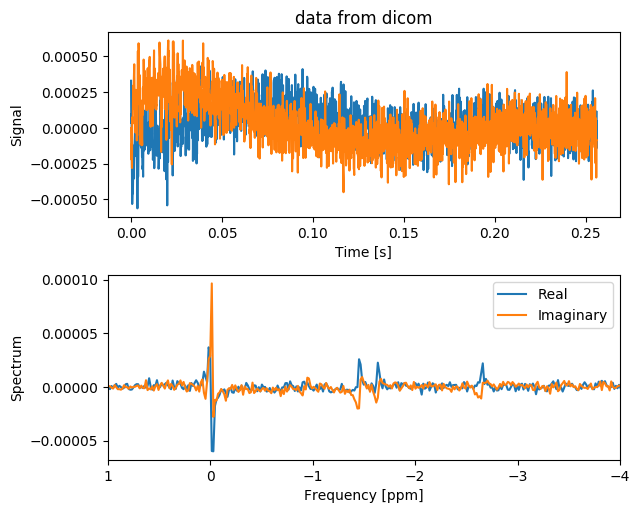

In [136]:
dicom1=SimSp(name='data from dicom',BW=4000,SD=0.256*1)
dicom1.sig=f1
dicom1.spec=fft.fftshift(fft.fft(dicom1.sig))*2/len(dicom1.sig)
dicom1.freq=fft.fftshift(fft.fftfreq(len(dicom1.sig)))*1*dicom1.BW

dicom1.autoshift()
plt.figure()

dicom1.show('both')
plt.xlim([1,-4])

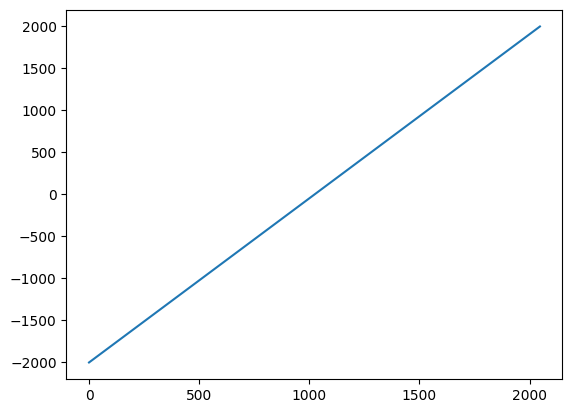

In [137]:
plt.figure
plt.plot(dicom1.freq)